# Trading the Strategy with IBKR's API

This code sets up a basic trading app using the Interactive Brokers API. The code connects to your paper trading account, allows you to define contracts, gather historical data, compute the crack spread, and execute orders.

**Jupyter notebooks environment**

- Jupyter notebooks allow creating and sharing documents that contain both code and rich text cells. If you are not familiar with Jupyter notebooks, read more [here](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html).
- Run each code cell to see its output **from top to bottom**. To run a cell, click within the cell and press **Shift/Command+Enter**, or click **Run** from the top of the page menu.
- A `[*]` symbol next to the cell indicates the code is still running. A `[ # ]` symbol, where `#` is an integer, indicates it is finished.
- Beware, **some code cells might take longer to run**, depending on the task, installing packages and libraries, training models, etc.

Please work top to bottom of this notebook and don't skip sections as this could lead to error messages due to missing code.

## Install the Interactive Brokers API

Download the Python API from the [Interactive Brokers GitHub page](http://interactivebrokers.github.io/).

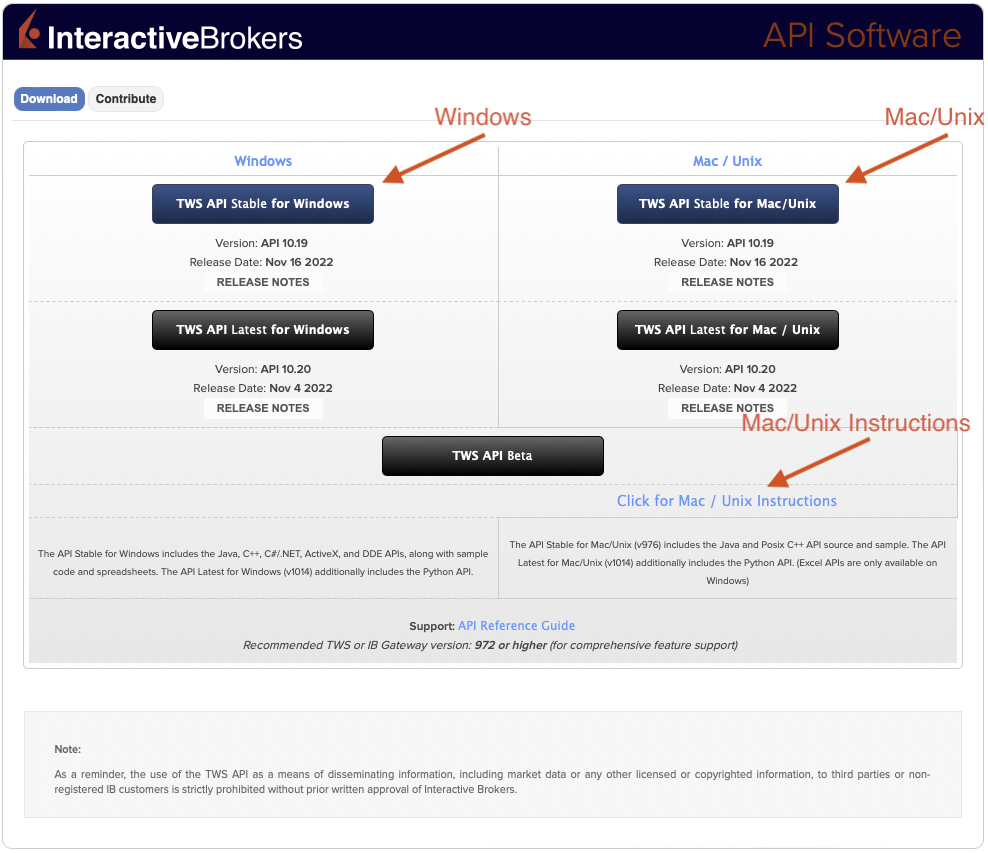

Download the stable API version for your operating system. The version may be different than what’s in the screenshot.

### **Windows**

To install on Windows, run the MSI file you downloaded and follow the setup wizard. The wizard installs files on your computer, including the files you need to install the API.

Navigate to the folder specified during the installation using the command prompt loaded with your custom Quant Lab (usually **\TWS API\source\pythonclient**).

The command to get there looks *something* like this:

```
cd "C:\Users\{YOUR USER NAME}\TWS API\source\pythonclient"
```

The location depends on where the files were placed on your computer. Pay attention during installation!

Once you're in the folder, run the following command:

```
pip install .
```

### **Mac/Unix/Linux**

It's a little trickier for Mac and Linux.

Navigate to the directory where the ZIP was downloaded using the Terminal loaded with your custom Quant Lab.

Unzip the installer like this:

```
unzip twsapi_macunix.N.M.zip -d $HOME/
```

> Important Note: You cannot unzip the file by double-clicking since it was compressed using Windows. You must unzip it from the command line.
> 
> 
> **Important Note:** Double-check the file name before running the command. The **N** and **M** above are placeholders. The filename will have numbers.
> 

Then, navigate to the directory with the installation files.

```
cd ~/IBJts/source/pythonclient
```

Once you're in the folder, run the following command:

```
pip install .
```

## Test the installation

Once the installation is complete, follow these steps to test it.

Type *python* at the Terminal window to enter Python:

```
python
```

Import the IB API to make sure it works:

```
>>> import ibapi
```

Nothing should happen, which means the API was correctly imported! Contact the community if you get an error about the module not being found.

Quit Python:

```
>>> exit()
```

After everything is working, it is safe to remove the Zip file you downloaded and the directories that you unzipped.

Now, install Interactive Brokers Trader Workstation (TWS), IB’s trading app. It’s great to use if you want to see what happens when you send trade orders with Python.

You can download TWS for your computer [here](https://www.interactivebrokers.com/en/trading/tws.php#tws-software). It's available for Windows, Mac, and Linux.

Once installed, start TWS.

If you have an account, log in. If not, you can use the Demo account option on the login screen.

You need to change some settings. Navigate to **Trader Workstation Configuration** under **Edit** –> **Global Configuration** –> **API** –> **Settings**. You should have a screen that looks like this:

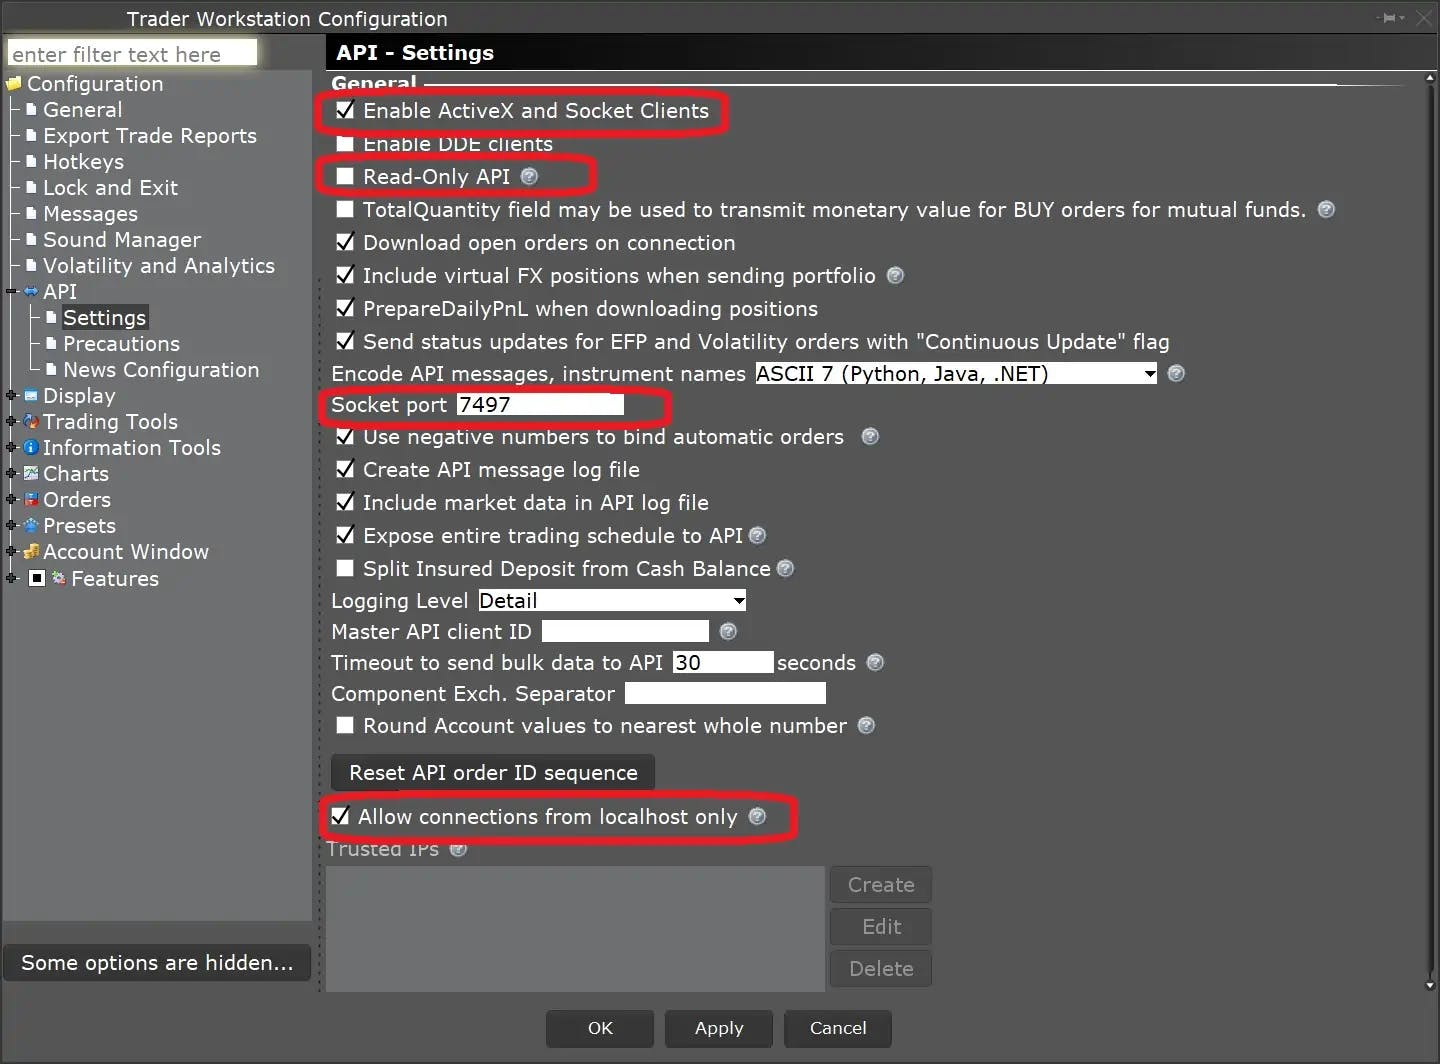

Make sure to check ***Enable ActiveX and Socket Clients***. Check ***Read-Only API*** if you want extra protection against sending orders to IB. Lastly, check ***Allow connections from localhost only*** for security.

Make a note of the ***Socket port,*** which you’ll need to connect through Python. For your paper trading account, the port defaults to 7497.

# Imports and set up

This code sets up the environment for building a trading system that connects to Interactive Brokers (IB). It imports Python’s standard libraries for timing, threading, type annotations, and data handling, then pulls in key IB API components: `EClient` for managing the connection, `EWrapper` for handling incoming data, `Contract` for defining instruments, `Order` for submitting trades, and `BarData` for working with historical price bars.

In [13]:
import time
import threading
from datetime import datetime
from typing import Dict, Optional
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from ibapi.order import Order
from ibapi.common import BarData

These imports are foundational when building an automated execution engine. They give you the ability to connect to Interactive Brokers, define the exact instruments you want to trade, submit orders programmatically, and process both historical and real-time market data. This infrastructure is essential for bridging the gap between strategy research and live trading execution.  

## Building our trading application

The `TradingApp` class is a Python application that interacts with the Interactive Brokers (IB) API. It extends `EClient` and `EWrapper` classes to manage connections, handle data, and execute trades. Below is a concise explanation of its key components:

### Class Overview
- **Parent Classes**: Inherits from `EClient` and `EWrapper`, enabling communication and interaction with the IB API.
- **Attributes**:
  - `data`: A dictionary storing historical data fetched from IB, indexed by request IDs.
  - `nextOrderId`: An integer storing the next valid order ID needed to place trades.

### Key Methods

1. **Initialization (`__init__`)**:
   - Initializes the `TradingApp` class.
   - Sets up the client and wrapper, and initializes the `data` dictionary to store historical data.

2. **Order ID Management (`nextValidId`)**:
   - Receives and sets the next valid order ID from IB.
   - Updates the `nextOrderId` attribute to ensure correct order placement.

3. **Fetching Historical Data (`get_historical_data`)**:
   - Requests historical market data for a given contract.
   - Stores the data in a Pandas DataFrame, indexed by time with columns for 'high', 'low', and 'close' prices.
   - Returns the DataFrame containing the historical data.

4. **Storing Historical Data (`historicalData`)**:
   - Processes and stores historical data received from IB callbacks.
   - Updates the DataFrame with high, low, and close prices based on the received data.

5. **Creating Stock Contract (`get_stock_contract`)**:
   - Creates a contract object for a stock based on the provided symbol.
   - Configures the contract to trade on the SMART exchange in USD.

6. **Creating Continuous Futures Contract (`get_cont_futures_contract`)**:
   - Creates a continuous futures contract object for the provided root symbol.
   - Configures the contract to trade on NYMEX in USD.

7. **Placing Orders (`place_order`)**:
   - Places an order using the provided contract, action (buy/sell), order type (e.g., market, limit), and quantity.
   - Uses the `nextOrderId`, places the order, increments the order ID, and confirms the order placement.

The `TradingApp` class facilitates automated trading by directly interacting with the IB API.  
It manages error handling, data requests, and order executions programmatically, providing a framework for developing automated trading strategies.

In [14]:
class TradingApp(EClient, EWrapper):
    """
    A trading application class that interacts with the Interactive Brokers (IB) API.
    This class handles connections, data requests, and order placements using 
    the IB API by extending the EClient and EWrapper classes.

    Attributes
    ----------
    data : dict
        A dictionary to store historical data fetched from IB, with request IDs as keys.
    nextOrderId : int or None
        Stores the next valid order ID to be used for placing trades.

    Methods
    -------
    nextValidId(orderId)
        Receives and sets the next valid order ID for placing trades.
    get_historical_data(reqId, contract)
        Requests and retrieves historical market data for a given contract.
    historicalData(reqId, bar)
        Processes and stores historical data received from IB callbacks.
    get_contract(symbol)
        Creates and returns a stock contract object based on the provided symbol.
    place_order(contract, action, order_type, quantity)
        Places an order using the provided contract, action, order type, and quantity.
    """

    def __init__(self) -> None:
        """
        Initializes the TradingApp instance, setting up the client and wrapper 
        components, and initializing data storage.
        """
        EClient.__init__(self, self)
        self.data: Dict[int, pd.DataFrame] = {}
        self.nextOrderId: Optional[int] = None

    def nextValidId(self, orderId: int) -> None:
        """
        Receives and sets the next valid order ID for placing trades.

        Parameters
        ----------
        orderId : int
            The next valid order ID received from IB.
        """
        super().nextValidId(orderId)
        self.nextOrderId = orderId

    def get_historical_data(self, reqId: int, contract: Contract) -> pd.DataFrame:
        """
        Requests and retrieves historical market data for a given contract.

        Parameters
        ----------
        reqId : int
            The request ID to associate with this historical data request.
        contract : ibapi.contract.Contract
            The contract object representing the financial instrument for which
            historical data is requested.

        Returns
        -------
        pandas.DataFrame
            A DataFrame containing the historical data, indexed by time with 
            columns for 'high', 'low', and 'close' prices.
        """
        self.data[reqId] = pd.DataFrame(columns=["time", "high", "low", "close"])
        self.data[reqId].set_index("time", inplace=True)
        self.reqHistoricalData(
            reqId=reqId,
            contract=contract,
            endDateTime="",
            durationStr="1 D",
            barSizeSetting="1 min",
            whatToShow="MIDPOINT",
            useRTH=0,
            formatDate=2,
            keepUpToDate=False,
            chartOptions=[],
        )
        time.sleep(5)
        return self.data[reqId]

    def historicalData(self, reqId: int, bar: BarData) -> None:
        """
        Processes and stores historical data received from IB callbacks.

        Parameters
        ----------
        reqId : int
            The request ID associated with this historical data.
        bar : ibapi.common.BarData
            The bar data received from IB containing high, low, and close prices.
        """
        # Get the current DataFrame at the request ID
        df = self.data[reqId]

        # Set the current bar data into the DataFrame
        df.loc[
            pd.to_datetime(bar.date, unit="s"), 
            ["high", "low", "close"]
        ] = [bar.high, bar.low, bar.close]

        # Cast data to floats
        df = df.astype(float)

        # Assign the DataFrame at the request ID
        self.data[reqId] = df

    def get_stock_contract(self, symbol: str) -> Contract:
        """
        Creates and returns a stock contract object based on the provided symbol.

        Parameters
        ----------
        symbol : str
            The ticker symbol of the stock.

        Returns
        -------
        ibapi.contract.Contract
            A Contract object configured for the specified stock symbol.
        """
        contract = Contract()
        contract.symbol = symbol
        contract.secType = "STK"
        contract.exchange = "SMART"
        contract.currency = "USD"
        return contract

    def get_cont_futures_contract(self, symbol: str) -> Contract:
        """
        Creates and returns a continuous futures contract object based on the provided symbol.

        Parameters
        ----------
        symbol : str
            The root symbol of the futures.

        Returns
        -------
        ibapi.contract.Contract
            A Contract object configured for the specified futures symbol.
        """
        contract = Contract()
        contract.symbol = symbol
        contract.secType = "CONTFUT"
        contract.exchange = "NYMEX"
        contract.currency = "USD"
        return contract

    def place_order(self, contract: Contract, action: str, order_type: str, quantity: int) -> None:
        """
        Places an order using the provided contract, action, order type, and quantity.

        Parameters
        ----------
        contract : ibapi.contract.Contract
            The financial instrument to be traded.
        action : str
            The action to take ('BUY' or 'SELL').
        order_type : str
            The type of order ('MKT', 'LMT', etc.).
        quantity : int
            The number of shares/contracts to trade.
        """
        order = Order()
        order.action = action
        order.orderType = order_type
        order.totalQuantity = quantity

        self.placeOrder(self.nextOrderId, contract, order)
        self.nextOrderId += 1
        print("Buy order placed")

# Build the helper functions

This function `compute_crack_321` calculates the 3:2:1 crack spread using closing prices for RBOB gasoline, Heating Oil, and WTI Crude Oil. It aligns the three input DataFrames by their index, drops missing data, converts gasoline and heating oil from dollars per gallon to dollars per barrel (by multiplying by 42), and applies the crack spread formula: `((2*RB*42) + (1*HO*42) - (3*CL)) / 3`. The output is a pandas Series of crack spread values in USD per barrel. 

In [15]:
def compute_crack_321(rb_df: pd.DataFrame, ho_df: pd.DataFrame, cl_df: pd.DataFrame) -> pd.Series:
    """
    Compute the 3:2:1 crack spread from RB, HO, and CL closes.

    The 3:2:1 crack approximates refinery margin using:
    ``crack = ((2 * RB * 42) + (1 * HO * 42) - (3 * CL)) / 3``.
    RB (RBOB) and HO (Heating Oil) are quoted in $/gal and are converted to $/bbl by multiplying by 42.
    CL (WTI) is quoted in $/bbl. Indices are aligned by inner join.

    Parameters
    ----------
    rb_df : pandas.DataFrame
        DataFrame containing a ``'close'`` column of RBOB prices (USD/gal).
    ho_df : pandas.DataFrame
        DataFrame containing a ``'close'`` column of Heating Oil prices (USD/gal).
    cl_df : pandas.DataFrame
        DataFrame containing a ``'close'`` column of WTI prices (USD/bbl).

    Returns
    -------
    pandas.Series
        Series of the 3:2:1 crack spread (USD/bbl), indexed by the intersection of the input indices.

    Notes
    -----
    - The function sorts by index and drops any rows with missing closes across inputs.
    - No backfilling/forward-filling is performed.
    - Expects a ``'close'`` column in each input; otherwise a ``KeyError`` is raised.

    Examples
    --------
    >>> crack = compute_crack_321(rb_df, ho_df, cl_df)
    >>> crack.tail(1).index[0]  # last aligned date
    """
    df = (
        pd.DataFrame({
            "RB": rb_df["close"],
            "HO": ho_df["close"],
            "CL": cl_df["close"],
        })
        .sort_index()
        .dropna()
    )
    crack = ((2 * df["RB"] * 42.0) + (1 * df["HO"] * 42.0) - (3 * df["CL"])) / 3.0
    return crack

This function is important because it encapsulates a standard refining margin calculation into reusable, testable code. The crack spread is a core energy market metric, and having a clean, vectorized implementation makes it easy to integrate into backtests, dashboards, or execution systems. By aligning indices and enforcing data integrity, the function ensures robustness and accuracy in any downstream trading strategy that relies on refinery economics.

This function `zscore` computes the rolling z-score of a given time series. It calculates the rolling mean and population standard deviation (`ddof=0`) over a specified window, then standardizes each value as `(x - μ) / σ`. The first `window - 1` values are `NaN` since there’s not enough data to compute statistics.  

In [16]:
def zscore(series: pd.Series, window: int) -> pd.Series:
    """
    Rolling z-score using population standard deviation.

    Computes ``z_t = (x_t - μ_t) / σ_t`` over a trailing window of length ``window``,
    where ``μ_t`` is the rolling mean and ``σ_t`` is the rolling std with ``ddof=0``.
    The first ``window-1`` observations are ``NaN``.

    Parameters
    ----------
    series : pandas.Series
        Input time series (numeric).
    window : int
        Lookback window length (> 1).

    Returns
    -------
    pandas.Series
        Rolling z-score with the same index as ``series``.

    Notes
    -----
    - Uses population standard deviation (``ddof=0``). For sample std, set ``ddof=1``.
    - ``min_periods`` defaults to ``window`` (no partial windows).

    Examples
    --------
    >>> z = zscore(crack, window=30)
    >>> z.dropna().iloc[0]  # first valid z-score
    """
    roll = series.rolling(window)
    mu = roll.mean()
    sig = roll.std(ddof=0)
    return (series - mu) / sig

This function is important because rolling z-scores are a standard way to detect when a series deviates significantly from its recent history. In algorithmic trading, they form the basis of mean-reversion strategies by flagging extreme values that are statistically unlikely. By using population standard deviation and enforcing full windows, the function provides consistent, rigorous signals suitable for backtesting and live trading.

This function `build_spread` constructs a simple spread between the 3:2:1 crack spread and a refiner’s stock price. It aligns both series by index, drops rows with missing values, subtracts the stock’s closing price from the crack spread, and returns the result as a Series named `"spread"`. 

In [17]:
def build_spread(crack: pd.Series, stock_close: pd.Series) -> pd.Series:
    """
    Construct a naive crack–refiner spread: crack minus stock price.

    Aligns the series by inner join and returns ``crack - stock_close``.
    Units differ (USD/bbl vs. USD/share); this is a toy spread for signal prototyping.
    Consider scaling/hedge ratios for production or beta neutrality in production use.

    Parameters
    ----------
    crack : pandas.Series
        3:2:1 crack spread (USD/bbl).
    stock_close : pandas.Series
        Refiner equity closing prices (USD/share).

    Returns
    -------
    pandas.Series
        Spread series named ``'spread'``, indexed by the intersection of inputs.

    Notes
    -----
    - Rows with missing values in either input are dropped.
    - For comparability, consider standardization (e.g., z-scores) or regression-based scaling.

    Examples
    --------
    >>> spread = build_spread(crack, mpc_close)
    >>> spread.name
    'spread'
    """
    df = pd.concat([crack.rename("crack"), stock_close.rename("stk")], axis=1).dropna()
    return (df["crack"] - df["stk"]).rename("spread")

This function is important because it translates economic intuition into a tradable time series. By comparing refinery margins to an equity valuation, traders can test relative value strategies and prototype mean-reversion signals. While the implementation is deliberately naive, it provides a clear foundation that can be extended with hedge ratios, scaling, or regression-based adjustments for production trading systems.

This helper function `_safe_last` safely extracts the last non-missing value from a specified column in a DataFrame. If the DataFrame is empty, the column doesn’t exist, or all values are `NaN`, it returns `np.nan`; otherwise, it returns the last valid value as a float.  

In [18]:
def _safe_last(df: pd.DataFrame, col: str) -> float:
    return float(df[col].dropna().iloc[-1]) if (len(df) and col in df and df[col].notna().any()) else np.nan

This function is important because financial time series often contain gaps, missing values, or unexpected structures. By safely handling these cases, it prevents errors when pulling the latest market prices or indicators. This makes it a reliable building block in live trading systems, where robustness against incomplete data is essential for stable execution.  

# Build the trading logic

### Class Overview
- **Parent Classes**: None (standalone strategy class that consumes a `TradingApp` instance).
- **Attributes**:
  - `app`: Reference to a `TradingApp` instance for data access and order execution.
  - `refiner_symbol`: The ticker symbol of the refiner stock to trade (default `"PSX"`).
  - `z_enter`: Z-score entry threshold for opening a position (default `-2.0`).
  - `z_exit`: Z-score exit threshold for closing a position (default `1.0`).
  - `window`: Rolling window length (in bars) for z-score calculation (default `120`).
  - `qty`: Trade size in shares/contracts (default `100`).
  - `in_position`: Tracks whether a long position is currently open.
  - `ct_rb`, `ct_ho`, `ct_cl`: Continuous futures contracts for RBOB gasoline, heating oil, and WTI crude.
  - `ct_stk`: Stock contract for the specified refiner.

### Key Methods

1. **Initialization (`__init__`)**:
   - Configures strategy parameters such as thresholds, window size, and quantity.
   - Creates IB contracts for energy futures (RB, HO, CL) and the refiner stock.

2. **Fetching Intraday Data (`fetch_1m_intraday`)**:
   - Requests 1-day, 1-minute historical data for RB, HO, CL futures and the refiner stock.
   - Ensures all returned DataFrames use proper `DatetimeIndex`.
   - Returns a dictionary of DataFrames keyed by symbol (`rb`, `ho`, `cl`, `stk`).

3. **Signal Computation (`compute_signal`)**:
   - Computes the 3:2:1 crack spread from futures data.
   - Builds a spread against the refiner’s stock price.
   - Normalizes the spread into a rolling z-score over the defined window.
   - Returns a DataFrame containing crack spread, stock price, spread, and z-score.

4. **Entry Rule (`_should_enter`)**:
   - Checks if z-score has just crossed below the entry threshold (`z_enter`).
   - Only triggers if no position is currently held.

5. **Exit Rule (`_should_exit`)**:
   - Checks if z-score has just crossed above the exit threshold (`z_exit`).
   - Only triggers if a position is currently held.

6. **Run Strategy Once (`run_once`)**:
   - Validates that `nextOrderId` is available from the IB connection.
   - Pulls fresh intraday data and computes the trading signal.
   - Logs the current z-score, thresholds, crack spread, and stock price.
   - Executes trades:
     - Places a **BUY** market order if entry condition is met.
     - Places a **SELL** market order if exit condition is met.
   - Updates `in_position` status accordingly.

This class `CrackVsRefinerStrategy` wires a live Interactive Brokers app into a rule-based trading system: it defines contracts (RB/HO/CL futures and a refiner stock), fetches 1-minute intraday data, computes the 3:2:1 crack, builds a crack–equity spread, standardizes it with a rolling z-score, and decides when to enter/exit based on threshold crossings. It maintains internal state (`in_position`), validates connection readiness (`nextOrderId`), logs the latest signal snapshot, and sends market orders on entry/exit events.

In [19]:
class CrackVsRefinerStrategy:
    def __init__(
        self,
        app: TradingApp,
        refiner_symbol: str = "PSX",
        z_enter: float = -2.0,
        z_exit: float = 1.0,
        window: int = 120,
        qty: int = 100,
    ):
        """
        Initialize crack-vs-refiner mean-reversion strategy.

        Parameters
        ----------
        app : TradingApp
            Connected IBKR client with:
            ``get_cont_futures_contract``, ``get_stock_contract``,
            ``get_historical_data``, ``place_order``, and ``nextOrderId``.
        refiner_symbol : str, default "PSX"
            Equity ticker for the refiner leg (e.g., VLO, MPC, PSX).
        z_enter : float, default -2.0
            Entry threshold. Enter long equity when z-score crosses *below* this value.
        z_exit : float, default 1.0
            Exit threshold. Flatten when z-score crosses *above* this value.
        window : int, default 120
            Lookback (bars) for rolling z-score.
        qty : int, default 100
            Share quantity per market order.

        Notes
        -----
        The strategy maintains state in ``self.in_position`` and uses 1-minute data
        as retrieved by :meth:`fetch_1m_intraday`.
        """
        self.app = app
        self.refiner_symbol = refiner_symbol
        self.z_enter = z_enter
        self.z_exit = z_exit
        self.window = window
        self.qty = qty
        self.in_position = False

        # Contracts
        self.ct_rb = self.app.get_cont_futures_contract("RB")
        self.ct_ho = self.app.get_cont_futures_contract("HO")
        self.ct_cl = self.app.get_cont_futures_contract("CL")
        self.ct_stk = self.app.get_stock_contract(refiner_symbol)

    def fetch_1m_intraday(self) -> Dict[str, pd.DataFrame]:
        """
        Fetch 1-day, 1-minute historical bars for RB, HO, CL, and the refiner equity.

        Returns
        -------
        dict of {str: pandas.DataFrame}
            A mapping with keys ``{"rb", "ho", "cl", "stk"}``. Each DataFrame is
            indexed by ``DatetimeIndex`` (UTC or exchange timezone as provided by
            IBKR) and contains at least a ``"close"`` column.
            Index values are coerced with ``pd.to_datetime`` if not already datetime.

        Notes
        -----
        - Relies on the app's ``get_historical_data`` configuration for bar size
          (1 min) and duration (1 day).
        - No resampling or forward-filling is performed here.
        """
        rb = self.app.get_historical_data(1001, self.ct_rb)
        ho = self.app.get_historical_data(1002, self.ct_ho)
        cl = self.app.get_historical_data(1003, self.ct_cl)
        stk = self.app.get_historical_data(1004, self.ct_stk)

        # Convert indexes safely (IB can send strings like '20250911 14:35:00')
        for df in (rb, ho, cl, stk):
            if not isinstance(df.index, pd.DatetimeIndex):
                df.index = pd.to_datetime(df.index, errors="coerce")

        return {"rb": rb, "ho": ho, "cl": cl, "stk": stk}

    def compute_signal(self, data: Dict[str, pd.DataFrame]) -> pd.DataFrame:
        """
        Compute crack, equity close, naive spread, and rolling z-score.

        Parameters
        ----------
        data : dict of {str: pandas.DataFrame}
            Output from :meth:`fetch_1m_intraday`. Each DataFrame must include a
            ``"close"`` column.

        Returns
        -------
        pandas.DataFrame
            Columns:
            - ``"crack"`` : 3:2:1 crack spread (USD/bbl).
            - ``"stk"``   : refiner equity close (USD/share).
            - ``"spread"``: ``crack - stk`` (toy spread; units differ).
            - ``"z"``     : rolling z-score of ``spread`` with lookback ``self.window``.
            Rows with any missing values are dropped; index is the inner join.

        Raises
        ------
        KeyError
            If expected keys (``"rb"``, ``"ho"``, ``"cl"``, ``"stk"``) or the
            ``"close"`` column are missing.

        Notes
        -----
        Uses population standard deviation (``ddof=0``) inside :func:`zscore`.
        """
        crack = compute_crack_321(data["rb"], data["ho"], data["cl"])
        stk_close = data["stk"]["close"]
        spr = build_spread(crack, stk_close)
        z = zscore(spr, self.window)
        out = pd.concat(
            [crack.rename("crack"), stk_close.rename("stk"), spr, z.rename("z")],
            axis=1,
        ).dropna()
        return out

    def _should_enter(self, z_series: pd.Series) -> bool:
        """
        Entry rule: cross *below* ``self.z_enter`` from above/at.

        Parameters
        ----------
        z_series : pandas.Series
            Z-score time series; last two observations are used.

        Returns
        -------
        bool
            ``True`` if not already in a position and the latest bar crosses
            from ``z_{t-1} >= z_enter`` to ``z_t < z_enter``; otherwise ``False``.

        Notes
        -----
        Requires at least two non-NaN observations. Does nothing if already in
        a position.
        """
        if len(z_series) < 2 or self.in_position:
            return False
        z_prev, z_now = float(z_series.iloc[-2]), float(z_series.iloc[-1])
        # Cross below enter threshold
        return (z_prev >= self.z_enter) and (z_now < self.z_enter)

    def _should_exit(self, z_series: pd.Series) -> bool:
        """
        Exit rule: cross *above* ``self.z_exit`` from below/at.

        Parameters
        ----------
        z_series : pandas.Series
            Z-score time series; last two observations are used.

        Returns
        -------
        bool
            ``True`` if currently in a position and the latest bar crosses
            from ``z_{t-1} <= z_exit`` to ``z_t > z_exit``; otherwise ``False``.

        Notes
        -----
        Requires at least two non-NaN observations. Only evaluated when
        ``self.in_position`` is ``True``.
        """
        if len(z_series) < 2 or not self.in_position:
            return False
        z_prev, z_now = float(z_series.iloc[-2]), float(z_series.iloc[-1])
        # Cross above exit threshold
        return (z_prev <= self.z_exit) and (z_now > self.z_exit)

    def run_once(self):
        """
        Single evaluation-and-trade step.

        Checks connectivity (``nextOrderId``), fetches fresh 1-minute data,
        recomputes signals, logs the current state, and places market orders
        per the entry/exit rules. Updates ``self.in_position`` accordingly.

        Returns
        -------
        None

        Raises
        ------
        RuntimeError
            If ``self.app.nextOrderId`` is not an ``int`` (not yet connected).

        Side Effects
        ------------
        - Calls ``self.app.place_order`` with ``order_type="MKT"`` and quantity
          ``self.qty``.
        - Prints a one-line status with timestamp, z, thresholds, crack, stock, and position flag.
        """
        if not isinstance(self.app.nextOrderId, int):
            raise RuntimeError("nextOrderId not set yet. Wait for nextValidId callback before running.")

        data = self.fetch_1m_intraday()
        frame = self.compute_signal(data)
        if frame.empty or frame["z"].isna().all():
            print("No signal computed (insufficient data).")
            return

        z_series = frame["z"]
        z_now = float(z_series.iloc[-1])
        crack_now = _safe_last(frame, "crack")
        stk_now = _safe_last(frame, "stk")

        print(f"[{frame.index[-1]}] z={z_now:.2f} thresh={self.z_enter}/{self.z_exit} crack={crack_now:.2f} stk={stk_now:.2f} pos={self.in_position}")

        if self._should_enter(z_series):
            print(f"ENTER long {self.refiner_symbol} @ z={z_now:.2f}")
            self.app.place_order(self.ct_stk, action="BUY", order_type="MKT", quantity=self.qty)
            self.in_position = True
        elif self._should_exit(z_series):
            print(f"EXIT {self.refiner_symbol} @ z={z_now:.2f}")
            self.app.place_order(self.ct_stk, action="SELL", order_type="MKT", quantity=self.qty)
            self.in_position = False


This structure is production-oriented: it enforces clean data alignment, avoids look-ahead with cross checks, and isolates decision logic in `_should_enter/_should_exit` for testability. Fetch–compute–act is a repeatable pattern you can schedule, scale, and monitor in live trading. Clear separation of concerns (data acquisition, signal computation, execution) reduces operational risk and accelerates iteration from research to deployment.

## Starting the trading app

This code initializes and connects a custom `TradingApp` instance to Interactive Brokers’ paper trading account. It connects on the local machine (`127.0.0.1`), using port `7497` and client ID `5`, then runs the app in a separate thread so the main program can continue executing. Finally, it enters a loop that waits until `app.nextOrderId` is available, confirming a successful connection before proceeding.

### Step-by-Step Breakdown

1. **Creating an Instance of the Trading App**: 
   - An instance of the `TradingApp` class is created, which handles interactions with the Interactive Brokers (IB) API, including data retrieval and order placement.

2. **Connecting to the IB Paper Trading Account**: 
   - The trading app is connected to the IB Gateway or Trader Workstation using the default local IP address and the port specific to paper trading. A unique client ID is used to distinguish this connection session from others.

3. **Starting the App on a Separate Thread**: 
   - The main loop of the trading app is started on a separate thread using Python’s threading capabilities. This allows the app to run in the background, ensuring the main program can continue executing other tasks concurrently.

4. **Checking Connection Status**: 
   - A loop continuously checks the app’s connection status by verifying if an order ID has been received from IB, which confirms the connection. If connected, it outputs a confirmation message; otherwise, it indicates that the app is still trying to establish the connection.

In [20]:
# Create an instance of our trading app
app = TradingApp()

# Connect the trading app to our paper trading account
# on port 7497 using client id 5
app.connect("127.0.0.1", 7497, clientId=5)

# Start the app on a thread so code can continue to execute
threading.Thread(target=app.run, daemon=True).start()

# Do a simple check to confirm we're connected
while True:
    if isinstance(app.nextOrderId, int):
        print("Connected")
        break
    else:
        print("Waiting for connection")
        time.sleep(1)

ERROR -1 1757608274369 2104 Market data farm connection is OK:cashfarm
ERROR -1 1757608274369 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 1757608274369 2104 Market data farm connection is OK:usopt
ERROR -1 1757608274369 2104 Market data farm connection is OK:usfarm
ERROR -1 1757608274370 2106 HMDS data farm connection is OK:euhmds
ERROR -1 1757608274370 2106 HMDS data farm connection is OK:fundfarm
ERROR -1 1757608274370 2106 HMDS data farm connection is OK:ushmds
ERROR -1 1757608274370 2158 Sec-def data farm connection is OK:secdefil


Waiting for connection
Connected


This connection sequence is critical because it establishes live communication with Interactive Brokers, enabling order submission and data requests. Running the app in a separate thread ensures the event-driven IB API loop doesn’t block the rest of your program. The connection check guarantees the trading system only proceeds when a reliable session with IB has been established, reducing the risk of failed trades or missed data.

> Important note: The "errors" being reported by the IB API are not errors. ALl messages from the IB API are returned through the same error callback and are labled as errors.

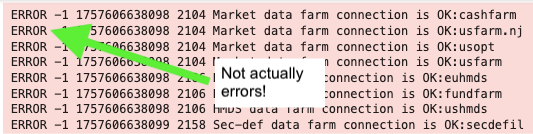

To check you're connected, click the DATA button and check for the connection.

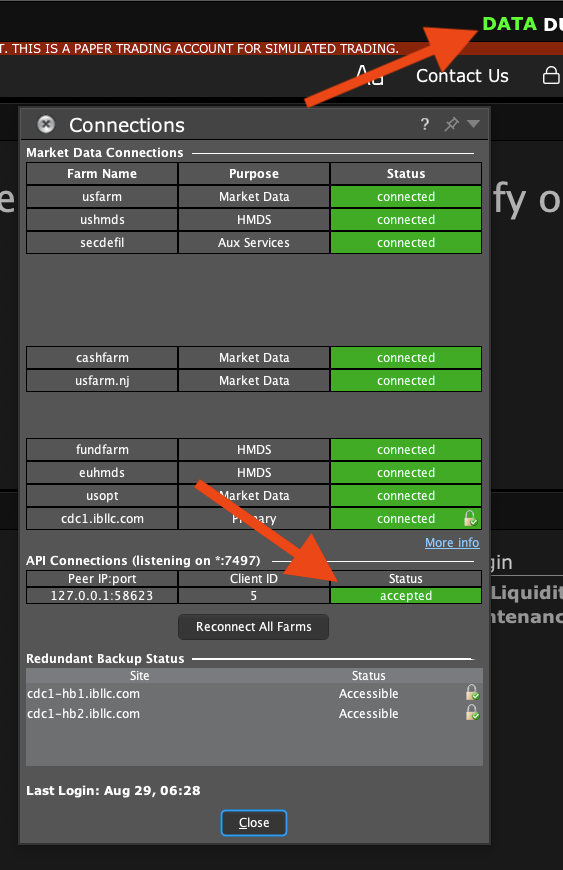

# Running the strategy

This code instantiates a `CrackVsRefinerStrategy` object, configured to trade Phillips 66 (`PSX`) using a z-score entry threshold of -2.0, exit threshold of 2.0, a 120-minute rolling window, and order size of 100 shares. It then runs a minimal polling loop that calls `strat.run_once()` every 30 seconds to check market conditions and update positions, until the user interrupts with a keyboard signal.

In [21]:
strat = CrackVsRefinerStrategy(
    app, 
    refiner_symbol="PSX", 
    z_enter=-2.0, 
    z_exit=2.0, 
    window=120, 
    qty=100
)

# Minimal intraday polling loop (e.g., run every 30 seconds)
try:
    while True:
        strat.run_once()
        time.sleep(30)  # 30 seconds
except KeyboardInterrupt:
    print("Disconnecting from the app")
    app.disconnect()
    pass

[2025-09-11 16:31:00] z=0.70 thresh=-0.1/0.1 crack=24.87 stk=158.68 pos=False
[2025-09-11 16:32:00] z=0.88 thresh=-0.1/0.1 crack=24.85 stk=158.61 pos=False
[2025-09-11 16:32:00] z=1.03 thresh=-0.1/0.1 crack=24.84 stk=158.56 pos=False
[2025-09-11 16:33:00] z=0.49 thresh=-0.1/0.1 crack=24.83 stk=158.69 pos=False
[2025-09-11 16:34:00] z=0.50 thresh=-0.1/0.1 crack=24.83 stk=158.68 pos=False
[2025-09-11 16:35:00] z=0.58 thresh=-0.1/0.1 crack=24.83 stk=158.66 pos=False
Disconnecting from the app


This loop operationalizes the strategy by continuously monitoring the market and executing trades according to defined rules. The scheduled polling ensures signals are acted on promptly without overwhelming the broker API. Such an event-driven structure is a practical template for moving from backtesting into live, automated trading with risk-controlled execution.